In [1]:
import omicverse as ov
import scanpy as sc

In [2]:
#设定绘图格式，分辨率300dpi等
ov.utils.ov_plot_set()

### 1. 数据导入
```python
# 无法下载
adata = sc.read_10x_h5(
    filename="filtered_feature_bc_matrix.h5",
  backup_url="https://figshare.com/ndownloader/files/39546196",
)
#adata=ov.utils.pancrea# https://figshare.com/articles/dataset/NeurIPS_2021_Benchmark_dataset/22716739
#NeurIPS 2021 Benchmark dataset
#Dataset posted on 2023-04-28, 16:51 authored by scverse, Malte Luecken
#Subset of the benchmark dataset published in Luecken et al. (2021).


#s1d3_filtered_feature_bc_matrix.h5 (19.49 MB)
#MD5 checksum:#
825f7f7578e3dc0b8955f5a97a402338
#https://figshare.com/ndownloader/files/40347880


#s1d1_filtered_feature_bc_matrix.h5 (21.79 MB)
#MD5 checksum:#
a99285913ea3f3d22600d3d2f8a88e4#
https://figshare.com/ndownloader/files/4034
s()

```

In [3]:
adata = sc.read_10x_h5(
    filename="data/s1d3_filtered_feature_bc_matrix.h5",
  backup_url="",
)
#adata = sc.read(
#    filename="data/endocrinogenesis_day15.h5ad",
#    backup_url="",
#)
adata

reading data/s1d3_filtered_feature_bc_matrix.h5
 (0:00:00)


AnnData object with n_obs × n_vars = 8340 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

- 数据集的形状为n_obs 8,340 x n_vars 36,601，这代表了 细胞标签 x 转录本数量 =  3,696 x 27998

- 函数var_names_make_unique()，通过将数字字符串附加到每个重复的索引元素（“1”、“2”等）来使变量名称var(=基因)唯一
- obs_names_make_unique()使obs（=细胞）唯一

In [4]:
adata.var_names_make_unique()
adata.obs_names_make_unique()

In [5]:
adata.var.head()

,gene_ids,feature_types,genome
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38
FAM138A,ENSG00000237613,Gene Expression,GRCh38
OR4F5,ENSG00000186092,Gene Expression,GRCh38
AL627309.1,ENSG00000238009,Gene Expression,GRCh38
AL627309.3,ENSG00000239945,Gene Expression,GRCh38


### 2. 过滤低质量的细胞

细胞质控通常对以下三个质控协变量进行   
- 每个条形码的计数数量(计数深度)  
- 每个条形码的基因数量     
- 每个条形码的线粒体基因计数比例    


In [6]:
# 线粒体基因
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# 核糖体基因
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# 血红蛋白基因
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

# 使用scanpy函数 sc.pp.calculate_qc_metrics 来计算协变量
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 8340 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

- n_genes_by_counts/detected_genes: 一个细胞中发现的有效基因数量（即表达量不为0）
- total_counts/nUMIs: 一个细胞中发现的分子数量（UMI），通常也可以被认为是这个细胞的文库大小
- pct_counts_mt/mito_perc: 一个细胞中线粒体基因的表达计数占比

In [7]:
#除了使用sc.pp.calculate_qc_metrics来计算协变量外，我们还可以手动计算。
#在这里，我们首先需要判断单细胞测序的矩阵格式，我们使用scipy.sparse的issparse来进行判断

#src='''
from scipy.sparse import issparse
if issparse(adata.X):
    adata.obs['nUMIs'] = adata.X.toarray().sum(axis=1)  
    adata.obs['mito_perc'] = adata[:, adata.var["mt"]].X.toarray().sum(axis=1) / adata.obs['nUMIs'].values
    adata.obs['detected_genes'] = (adata.X.toarray() > 0).sum(axis=1)  
else:
    adata.obs['nUMIs'] = adata.X.sum(axis=1)  
    adata.obs['mito_perc'] = adata[:, adata.var["mt"]].X.sum(axis=1) / adata.obs['nUMIs'].values
    adata.obs['detected_genes'] = (adata.X > 0).sum(axis=1)  
    
adata.obs[['nUMIs','total_counts','n_genes_by_counts','detected_genes','pct_counts_mt','mito_perc',]]
#'''

,nUMIs,total_counts,n_genes_by_counts,detected_genes,pct_counts_mt,mito_perc
AAACCCAAGAAGTGTT-1,5739.0,5739.0,1391,1391,6.586514,0.065865
AAACCCAAGCTGACTT-1,5334.0,5334.0,1625,1625,9.280090,0.092801
AAACCCACAAATGGCG-1,6661.0,6661.0,2400,2400,6.830806,0.068308
AAACCCACATAGAATG-1,6712.0,6712.0,1743,1743,7.166269,0.071663
AAACCCAGTCTTCTAT-1,5535.0,5535.0,2113,2113,5.962059,0.059621
...,...,...,...,...,...,...
TTTGTTGAGAGTCTGG-1,615.0,615.0,277,277,45.853661,0.458537
TTTGTTGCAGACAATA-1,13218.0,13218.0,3797,3797,6.536541,0.065365
TTTGTTGCATGTTACG-1,27280.0,27280.0,3089,3089,3.757332,0.037573
TTTGTTGGTAGTCACT-1,698.0,698.0,379,379,20.487106,0.204871


In [8]:
adata.var.head()

,gene_ids,feature_types,genome,mt,ribo,hb,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,False,False,False,0,0.000000,0.000000,100.000000,0.0,0.000000
FAM138A,ENSG00000237613,Gene Expression,GRCh38,False,False,False,0,0.000000,0.000000,100.000000,0.0,0.000000
OR4F5,ENSG00000186092,Gene Expression,GRCh38,False,False,False,0,0.000000,0.000000,100.000000,0.0,0.000000
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,False,False,False,15,0.001799,0.001797,99.820144,15.0,2.772589
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,False,False,False,1,0.000120,0.000120,99.988010,1.0,0.693147


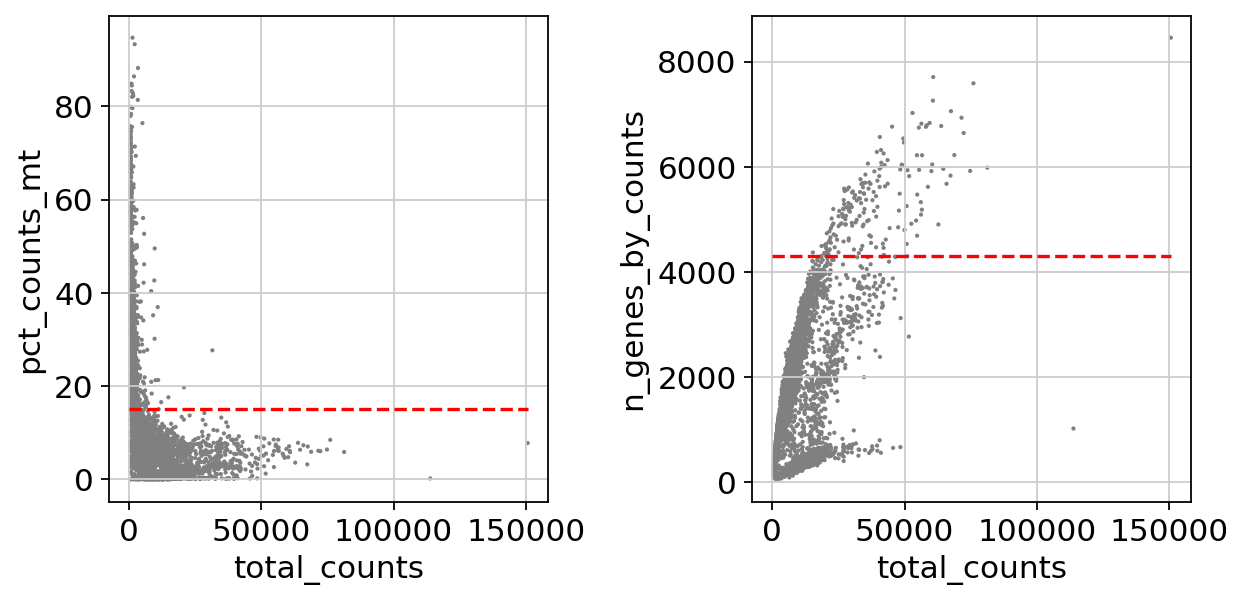

In [9]:
import matplotlib.pyplot as plt
mito_filter = 15
n_counts_filter = 4300
fig, axs = plt.subplots(ncols = 2, figsize = (8,4))
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt',ax = axs[0], show=False)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',ax = axs[1], show = False)
#draw horizontal red lines indicating thresholds.
axs[0].hlines(y = mito_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
axs[1].hlines(y = n_counts_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
fig.tight_layout()
plt.show()

在scanpy的官方教程中，
高计数的细胞被认为是双细胞进而过滤，所以我们绘制了两条红线，
但在我们的教程中，对于双细胞我们将采用其他方法进行过滤，
所以我们只需要对一些低表达的细胞进行质控，
比如nUMI小于500的细胞，比如detected_gene小于250的细胞，线粒体基因的计数比例不超过15%。
但这个过滤我们要在双细胞过滤完后再进行。



In [10]:
# Original QC plot
n0 = adata.shape[0]
print(f'Original cell number: {n0}')

Original cell number: 8340


### 3. 双细胞的过滤

+ 双细胞被定义为在相同的细胞条形码（barcode）下进行测序的两个细胞

- 双细胞被定义为在相同的细胞条形码（barcode）下进行测序的两个细胞
- 它们被捕获在同一个液滴（droplet）中。这也是为什么使用barcode而不是cells的原因

+ 同型(homotypic)：同型通常被认为是不影响下游分析的，因为其是由一类相同的细胞中的两个所构成，所以这部分细胞不是我们所需要过滤的对象
+ 异型(heterotypic)：异型通常是由来自两类不同的细胞所构成的，异型的存在会使得我们后续的细胞分类出现错误，因为其独特的数据分布特征。

##### 使用scrublet来完成双细胞的识别

In [11]:
print('Begin of post doublets removal and QC plot')
sc.external.pp.scrublet(adata, random_state=112)
adata = adata[adata.obs['predicted_doublet']==False, :].copy()
n1 = adata.shape[0]
print(f'Cells retained after scrublet: {n1}, {n0-n1} removed.')
print(f'End of post doublets removal and QC plots.')

Begin of post doublets removal and QC plot
Running Scrublet
filtered out 15203 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.26
Detected doublet rate = 2.2%
Estimated detectable doublet fraction = 35.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 6.3%
    Scrublet finished (0:00:11)
Cells retained after scrublet: 8154, 186 removed.
End of post doublets removal and QC plots.


### 4. 手动/自动过滤低质量reads细胞
将adata复制成两份

In [12]:
adata_manual=adata.copy()
adata_auto=adata.copy()

### 4.1 手动过滤低质量reads的细胞
使用该过滤字典完成过滤操作

In [13]:
import numpy as np
tresh={'mito_perc': 0.15, 'nUMIs': 500, 'detected_genes': 250}

adata_manual.obs['passing_mt'] = adata_manual.obs['mito_perc'] < tresh['mito_perc']
adata_manual.obs['passing_nUMIs'] = adata_manual.obs['nUMIs'] > tresh['nUMIs']
adata_manual.obs['passing_ngenes'] = adata_manual.obs['detected_genes'] > tresh['detected_genes']

print(f'Lower treshold, nUMIs: {tresh["nUMIs"]}; filtered-out-cells: {n1-np.sum(adata_manual.obs["passing_nUMIs"])}')
print(f'Lower treshold, n genes: {tresh["detected_genes"]}; filtered-out-cells: {n1-np.sum(adata_manual.obs["passing_ngenes"])}')
print(f'Lower treshold, mito %: {tresh["mito_perc"]}; filtered-out-cells: {n1-np.sum(adata_manual.obs["passing_mt"])}')

Lower treshold, nUMIs: 500; filtered-out-cells: 3
Lower treshold, n genes: 250; filtered-out-cells: 216
Lower treshold, mito %: 0.15; filtered-out-cells: 1447


取保留的细胞的交集

In [14]:
QC_test = (adata_manual.obs['passing_mt']) & (adata_manual.obs['passing_nUMIs']) & (adata_manual.obs['passing_ngenes'])
removed = QC_test.loc[lambda x : x == False]
print(f'Total cell filtered out with this last  QC (and its chosen options): {n1-np.sum(QC_test)}')
adata_manual = adata_manual[QC_test, :].copy()
n2 = adata_manual.shape[0]
    
# Store cleaned adata
print(f'Cells retained after scrublet and filtering: {n2}, {n0-n2} removed.')

Total cell filtered out with this last  QC (and its chosen options): 1555
Cells retained after scrublet and filtering: 6599, 1741 removed.


还需要过滤掉一些从基因和细胞层面低计数的细胞/基因

In [15]:
# Last gene and cell filter
sc.pp.filter_cells(adata_manual, min_genes=200)
sc.pp.filter_genes(adata_manual, min_cells=3)

adata_manual

filtered out 15624 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 6599 × 20977
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'nUMIs', 'mito_perc', 'detected_genes', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet'

### 4.2 自动过滤低质量reads的细胞
首先设定好基础阈值  
tresh={'mito_perc': 0.15, 'nUMIs': 500, 'detected_genes': 250}  
在omicverse里，预先设定好了ov.pp._qc.mads和ov.pp._qc.mads_test两个函数，来计算MAD值

In [16]:
adata_auto.obs['passing_mt'] = adata_auto.obs['mito_perc'] < tresh['mito_perc']
adata_auto.obs['passing_nUMIs'] = ov.pp._qc.mads_test(adata_auto.obs, 'nUMIs', nmads=5, lt=tresh)
adata_auto.obs['passing_ngenes'] = ov.pp._qc.mads_test(adata_auto.obs, 'detected_genes', nmads=5, lt=tresh)  

nUMIs_t = ov.pp._qc.mads(adata_auto.obs, 'nUMIs', nmads=5, lt=tresh)
n_genes_t = ov.pp._qc.mads(adata_auto.obs, 'detected_genes', nmads=5, lt=tresh)
print(f'Tresholds used, nUMIs: ({nUMIs_t[0]}, {nUMIs_t[1]}); filtered-out-cells: {n1-np.sum(adata_auto.obs["passing_nUMIs"])}')
print(f'Tresholds used, n genes: ({n_genes_t[0]}, {n_genes_t[1]}); filtered-out-cells: {n1-np.sum(adata_auto.obs["passing_ngenes"])}')
print(f'Lower treshold, mito %: {tresh["mito_perc"]}; filtered-out-cells: {n1-np.sum(adata_auto.obs["passing_mt"])}')

Tresholds used, nUMIs: (500, 19212.5); filtered-out-cells: 521
Tresholds used, n genes: (250, 4136.0); filtered-out-cells: 412
Lower treshold, mito %: 0.15; filtered-out-cells: 1447


保留需要的细胞取交集

In [17]:
QC_test = (adata_auto.obs['passing_mt']) & (adata_auto.obs['passing_nUMIs']) & (adata_auto.obs['passing_ngenes'])
removed = QC_test.loc[lambda x : x == False]
print(f'Total cell filtered out with this last  QC (and its chosen options): {n1-np.sum(QC_test)}')
adata_auto = adata_auto[QC_test, :].copy()
n2 = adata_auto.shape[0]
    
# Store cleaned adata
print(f'Cells retained after scrublet and filtering: {n2}, {n0-n2} removed.')

Total cell filtered out with this last  QC (and its chosen options): 2082
Cells retained after scrublet and filtering: 6072, 2268 removed.


过滤掉一些从基因和细胞层面低计数的细胞/基因

In [18]:
# Last gene and cell filter
sc.pp.filter_cells(adata_auto, min_genes=200)
sc.pp.filter_genes(adata_auto, min_cells=3)

adata_auto

filtered out 16377 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 6072 × 20224
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'nUMIs', 'mito_perc', 'detected_genes', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet'

自动过滤会比手动过滤去除掉更多的细胞，这是因MAD的识别完全从数据的角度出发，去除了离群的值，但是我们手动过滤没有对离群的值进行过滤，而是全部保留。

omicverse中，我们提供了ov.pp.qc函数来完成质控的所有步骤。该函数的参数如下：

- mode: 我们可以指定为'seurat'或'mads',如果为seurat，那么则是执行上面的手动过滤步骤，如果是mads，则是自动过滤步骤
- min_cells: 一个基因最少在多少个细胞中表达，如果设定为3，那么意味着表达少于3个细胞的基因都将被过滤掉
- min_genes: 一个细胞最少表达多少个基因，如果设定为200，那么意味着表达量小于200的细胞都将被过滤掉
- nmads: MADs的倍数，前面有阐述，默认5倍为离群值
- tresh=None
如果tresh==None，那么其自动设置为{'mito_perc': 0.15, 'nUMIs': 500, 'detected_genes': 250}

In [19]:
adata=ov.pp.qc(adata,
         tresh={'mito_perc': 0.05, 'nUMIs': 500, 'detected_genes': 250})
adata

Calculate QC metrics
End calculation of QC metrics.
Original cell number: 8154
Begin of post doublets removal and QC plot
Running Scrublet
filtered out 15307 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.58
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 23.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%
    Scrublet finished (0:00:10)
Cells retained after scrublet: 8154, 0 removed.
End of post doublets removal and QC plots.
Filters application (seurat or mads)
Lower tresho

AnnData object with n_obs × n_vars = 2447 × 17053
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'nUMIs', 'mito_perc', 'detected_genes', 'doublet_score', 'predicted_doublet', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet'

In [22]:
adata.write_h5ad('data/sc01.after_quality_control.h5ad', compression='gzip')

### 5 环境 RNA 的校正

注：本节可能会导致计数矩阵不为整数，使得部分包失效，所以该分析除非你很明确环境RNA的干扰十分严重，
不然我认为是可以被跳过的。

对于基于液滴的单细胞 RNA-seq 实验，一定数量的背景 mRNA 存在于稀释液中，与细胞一起分布在液滴中，并随之测序。
这样做的最终结果是产生一种背景污染，这种污染表现的不是液滴中所含细胞的表达，而是包含细胞的溶液。

基于液滴的 scRNA-seq 为多个细胞的基因产生独特的分子标识符(UMI)计数，目的是确定每个基因和每个细胞的分子数量。它假设每个液滴都含有来自单个细胞的 mRNA。重复，空液滴和无细胞 RNA 可以打破这一假设。

无细胞的 mRNA 分子代表存在于稀释液中的背景 mRNA。
输入溶液中这种无细胞 mRNA 的污染通常被称为细胞溶解产生的“soup”。

无细胞的 mRNA 分子，也被称为环境 RNA，可以混淆观察到的计数的数量，可以被看作是背景污染。

我们推荐使用soupX包来完成环境RNA的校正，由于环境RNA的校正需要用到raw_feature_bc_matrix文件，该文件大部分文章都不会上传到公开数据集，所以感兴趣的读者可以自行研究soupX的教程。或者从单细胞最佳实践的英文版教程中完成该分析

[SoupX](https://github.com/constantAmateur/SoupX)

```Rscript
library(SoupX)
library(DropletUtils)

sc = load10X('path/to/your/cellranger/outs/folder')
if (is.null(rho)) {
tryCatch(
{sc = autoEstCont(sc)}, 
error=function(e) {
#因为自动计算经常会报错，所以如果报错则设置rho为0.2
print("autoEstCont Error !")
sc = setContaminationFraction(sc, 0.2)}
)
}else{
#自行设置污染比例系数
sc = setContaminationFraction(sc, rho)
}

#校正矩阵
out = adjustCounts(sc)
#保存两个矩阵文件
saveRDS(sc,"sc.rds")
#保存校正后的矩阵，输出为10X格式
DropletUtils:::write10xCounts("./soupX_matrix", out,version="3")
```
[结合Seurat批量去除环境RNA污染（SoupX）2022-05-19](https://www.jianshu.com/p/b9799b401f8f)

```Rscript
##参数简介
#toc是分析矩阵，即有过滤的矩阵
#tod是全矩阵，即没有任何过滤的矩阵
#rho是污染比例系数，可自行设置，如果不设置则会自动计算

run_soupx <- function(toc,tod,rho=NULL) {
toc <- Read10X(toc,gene.column=1)
tod <- Read10X(tod,gene.column=1)

#保证基因名一致
tod <- tod[rownames(toc),]

##SoupX帮助文档建议提供分析矩阵的聚类亚群分组，因此这里利用分析矩阵做一个简单聚类
all <- toc
all <- CreateSeuratObject(all)
all <- NormalizeData(all, normalization.method = "LogNormalize", scale.factor = 10000)
all <- FindVariableFeatures(all, selection.method = "vst", nfeatures = 3000)
all.genes <- rownames(all)
all <- ScaleData(all, features = all.genes)
all <- RunPCA(all, features = VariableFeatures(all), npcs = 40, verbose = F)
all <- FindNeighbors(all, dims = 1:30)
all <- FindClusters(all, resolution = 0.5)
all <- RunUMAP(all, dims = 1:30)
#提取聚类后的meta.data信息
matx <- all@meta.data

sc = SoupChannel(tod, toc)
sc = setClusters(sc, setNames(matx$seurat_clusters, rownames(matx)))
#自动计算污染比例系数
if (is.null(rho)) {
tryCatch(
{sc = autoEstCont(sc)}, 
error=function(e) {
#因为自动计算经常会报错，所以如果报错则设置rho为0.2
print("autoEstCont Error !")
sc = setContaminationFraction(sc, 0.2)}
)
}else{
#自行设置污染比例系数
sc = setContaminationFraction(sc, rho)
}
#校正矩阵
out = adjustCounts(sc)
#保存两个矩阵文件
saveRDS(sc,"sc.rds")
#保存校正后的矩阵，输出为10X格式
DropletUtils:::write10xCounts("./soupX_matrix", out,version="3")
}
```